# Análise Exploratória

O objetivo deste notebook é explorar os dados e analisar algumas hipóteses antes de treinar o modelo em outro notebook.

Esclarecendo que o objetivo deste desafio é obter um modelo de alta exatidão (accuracy) (soma de verdadeiros-positivos e verdadeiros-negativos dividida pelo total) que prediz os sobreviventes do RMS Titanic.

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import path

In [76]:
data_folder = "data"
raw_folder = "raw"
train_file = "train.csv"

train_path = path.join(data_folder, raw_folder, train_file)

train = pd.read_csv(
    train_path,
    header=0,
    names=[
        "passenger_id",
        "survived",
        "p_class",
        "name",
        "sex",
        "age",
        "sib_sp",
        "par_ch",
        "ticket",
        "fare",
        "cabin",
        "embarked",
    ],
    dtype={"sex": "category", "embarked": "category"},
)
train.head()

,passenger_id,survived,p_class,name,sex,age,sib_sp,par_ch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   passenger_id  891 non-null    int64   
 1   survived      891 non-null    int64   
 2   p_class       891 non-null    int64   
 3   name          891 non-null    object  
 4   sex           891 non-null    category
 5   age           714 non-null    float64 
 6   sib_sp        891 non-null    int64   
 7   par_ch        891 non-null    int64   
 8   ticket        891 non-null    object  
 9   fare          891 non-null    float64 
 10  cabin         204 non-null    object  
 11  embarked      889 non-null    category
dtypes: category(2), float64(2), int64(5), object(3)
memory usage: 71.7+ KB


Da página de desafio, temos o dicionário dos dados, copiado para aqui para fácil referência.

| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


## Hipóteses

Vamos analisar algumas hipóteses, tentando descobrir a relevância das features presentes para o target (survived).

#### Hipótese 1 - Mulheres tem maior probabilidade de sobreviver.

Hipótese que é levantada na própria página do desafio e bastante esperada devido a cultura da época.

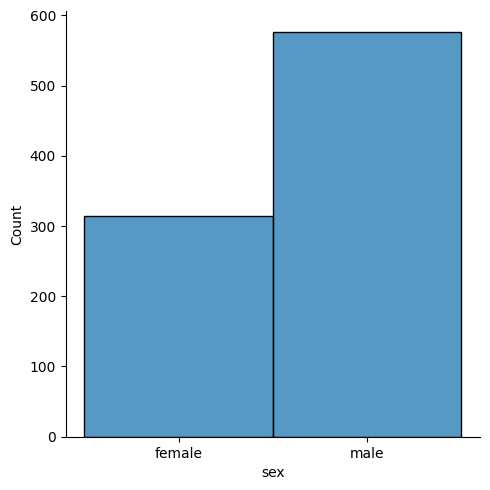

In [78]:
sns.displot(train, x="sex")

In [79]:
women = train.loc[train.sex == "female"]["survived"]
percentual_women = sum(women) / len(women)

print("Percentual de mulheres que sobreviveram:", percentual_women)

Percentual de mulheres que sobreviveram: 0.7420382165605095


In [80]:
men = train.loc[train.sex == "male"]["survived"]
percentual_men = sum(men) / len(men)

print("Percentual de homens que sobreviveram:", percentual_men)

Percentual de homens que sobreviveram: 0.18890814558058924


In [112]:
sex_df = train.loc[:, ["survived", "sex"]]
# removendo os dois que não tem informação, assumindo que eles nunca embarcaram.
sex_df["sex"] = sex_df["sex"].replace(
    {
        "female": 1,
        "male": 0,
    }
)
sex_df["sex"] = pd.to_numeric(sex_df["sex"])
sex_df.corr()

,survived,sex
survived,1.000000,0.543351
sex,0.543351,1.000000


É notável a relação entre sexo e a chance de sobreviver para esse caso, sendo um provável Feature relevante.

#### Hipótese 2 - Quão mais jovem o passageiro, maior a chance de sobreviver.

Supondo que a confusão, stress e acidentes possam ter levado a morte de passageiros mais velhos e que crianças tinham prioridade nos botes.
Primeiro, analisando a distribuição de idades dos passageiros vemos que é um gráfico enviesado a direita, com um pico menor nos bebês.

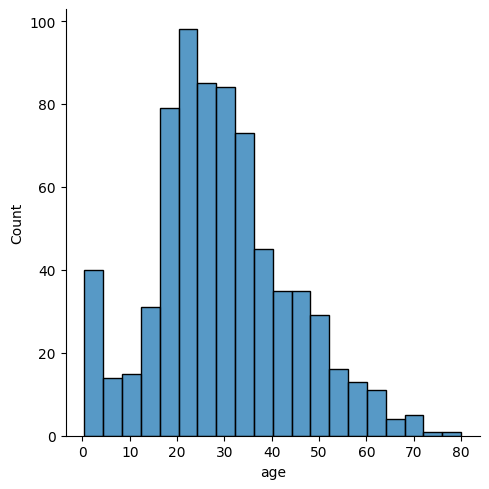

In [81]:
sns.displot(train, x="age")

Analisando a correlação entre idade e sobrevivência, pelo método de Pearson, mostra pouca correlação negativa. Então, usar a idade puramente pode não ser um Feature tão interessante. Ainda assim, podemos analisar alguns grupos derivados da idade.

In [82]:
train[["age", "survived"]].corr()

,age,survived
age,1.000000,-0.077221
survived,-0.077221,1.000000


In [83]:
old = train.loc[train["age"].le(6)]["survived"]
percentual_old = sum(old) / len(old)

print("Percentual de bebês que sobreviveram:", percentual_old)

Percentual de bebês que sobreviveram: 0.7021276595744681


In [84]:
old = train.loc[(train["age"].gt(6)) & (train["age"].le(18))]["survived"]
percentual_old = sum(old) / len(old)

print("Percentual de crianças que sobreviveram:", percentual_old)

Percentual de crianças que sobreviveram: 0.40217391304347827


In [85]:
old = train.loc[(train["age"].gt(18)) & (train["age"].le(60))]["survived"]
percentual_old = sum(old) / len(old)

print("Percentual de adultos que sobreviveram:", percentual_old)

Percentual de adultos que sobreviveram: 0.3887884267631103


In [86]:
old = train.loc[train["age"].gt(60)]["survived"]
percentual_old = sum(old) / len(old)

print("Percentual de idosos que sobreviveram:", percentual_old)

Percentual de idosos que sobreviveram: 0.22727272727272727


Crianças, adolescentes, adultos e idosos tem valores menores que 50% de sobrevivência, especialmente idosos com menos de 25% de chance apenas. Em contraste, bebês tem aproximadamente 70% de chance de sobrevivência. Alguns Features podem ser derivados dessa idade então. 

In [87]:
age_df = train.loc[:, ("survived", "age")]
age_df["baby"] = age_df["age"].le(6)
age_df["child"] = np.logical_and(age_df["age"].gt(6), (age_df["age"].le(18)))
age_df["adult"] = np.logical_and(age_df["age"].gt(18), (age_df["age"].le(60)))
age_df["elder"] = age_df["age"].gt(60)
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   age       714 non-null    float64
 2   baby      891 non-null    bool   
 3   child     891 non-null    bool   
 4   adult     891 non-null    bool   
 5   elder     891 non-null    bool   
dtypes: bool(4), float64(1), int64(1)
memory usage: 17.5 KB


In [88]:
age_df.corr()

,survived,age,baby,child,adult,elder
survived,1.000000,-0.077221,0.154447,0.012794,0.013019,-0.051224
age,-0.077221,1.000000,-0.493224,-0.394761,0.424660,0.446160
baby,0.154447,-0.493224,1.000000,-0.080075,-0.301844,-0.037547
child,0.012794,-0.394761,-0.080075,1.000000,-0.434035,-0.053991
adult,0.013019,0.424660,-0.301844,-0.434035,1.000000,-0.203519
elder,-0.051224,0.446160,-0.037547,-0.053991,-0.203519,1.000000


Novos features tem no geral uma maior correlação do que a idade pura, mas ainda é um grau baixo.

#### Hipótese 3 - Passageiros de classes mais elevadas, sobreviveram mais.

Supondo que houve preferência na divisão dos botes ou que a posição dos passageiros durante o acidente impactou a sobrevivência.

Pela distribuição, a maioria dos passageiros eram de terceira classe, com a soma da primeira e segunda classe sendo menor que o total da terceira.

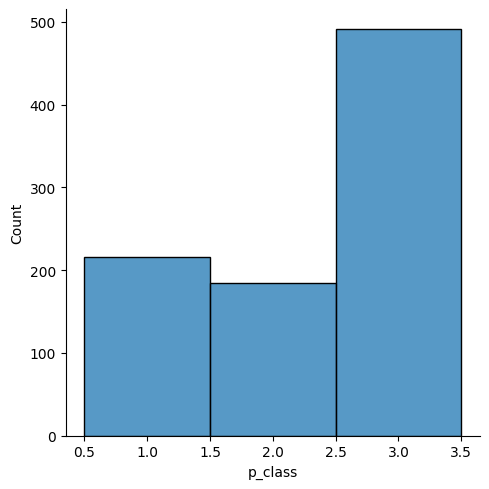

In [89]:
sns.displot(train, x="p_class", kind="hist", discrete=True)

Analisando os percentuais de sobrevivência, vemos quase o triplo percentual entre terceira e primeira classe.

In [90]:
first = train.loc[train["p_class"].eq(1)]["survived"]
percentual_first = sum(first) / len(first)

print("Percentual de 1ª classe sobrevivente:", percentual_first)

Percentual de 1ª classe sobrevivente: 0.6296296296296297


In [91]:
second = train.loc[train["p_class"].eq(2)]["survived"]
percentual_second = sum(second) / len(second)

print("Percentual de 2ª classe sobrevivente:", percentual_second)

Percentual de 2ª classe sobrevivente: 0.47282608695652173


In [92]:
third = train.loc[train["p_class"].eq(3)]["survived"]
percentual_third = sum(third) / len(third)

print("Percentual de 3ª classe sobrevivente:", percentual_third)

Percentual de 3ª classe sobrevivente: 0.24236252545824846


E analisando a correlação, temos um grau moderado entre a classe e sobrevivência. Assim, essa também deve ser uma Feature interessante.

In [93]:
train[["survived", "p_class"]].corr()

,survived,p_class
survived,1.000000,-0.338481
p_class,-0.338481,1.000000


#### Hipótese 4 - Passageiros de cabines inferiores teriam menos chance de sobrevivência.

Analisando um dado além do providos pela competição, mas que pode ser relevante, é a posição da cabine. Titanic possuía 10 decks, que vão do deck superior (A) até as cabines do motor no deck inferior. Pelas informações [históricas registradas](https://www.encyclopedia-titanica.org/titanic-deckplans/), podemos visualizar isso, pareado com a lógica de [distribuição das cabines](https://titanic.fandom.com/wiki/Category:Decks) entendemos que a primeira classe ficava nos decks superiores, seguida pela segunda classe e então a terceira nos inferiores. Nesse sentido, ambas Features podem ter uma alta correlação entre si.

Como vemos nas informações do dataset, há uma grande falta de dados sobre as cabines. Poderíamos inferir algo vindo da classe do ticket do passageiro, mas isso reduziria o impacto dessa Feature no restante do modelo.

In [94]:
train["cabin"].isna().value_counts()

True     687
False    204
Name: cabin, dtype: int64

No momento, pela falta de informação e o risco de não ter uma grande contribuição para o modelo pelo esforço usado para desenvolve-la, deixaremos essa hipótese de lado.

#### Hipótese 5 - Passageiros que pagaram um valor mais alto, tiveram prioridade.

Hipótese semelhante à da classe do passageiro, mas nesse caso veremos se o valor do ticket em si acrescentaria algo a mais para o modelo.

Analisaremos levando em consideração a p_class também.

Pela distribuição, vemos que ela também é enviesada à direita. Além disso, praticamente todos os valores acima de $80 são da primeira classe, com a segunda e terceira juntas nos valores inferiores.

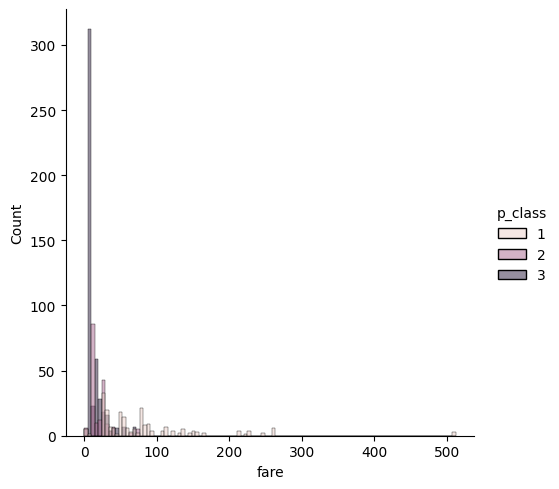

In [95]:
sns.displot(train, x="fare", hue="p_class")

Analisando a matriz de correlação tanto pelo método de Pearson (no caso para analisar a relação mais categórica entre p_class e survived) quanto Spearman (para fare e survived), vemos que há correlações moderadas para intensas entre as 3 variáveis. Entretanto, isso também significa que parte do impacto de fare esteja 'diluído' na p_class.

De qualquer forma, ela ainda pode ser uma Feature interessante.

In [96]:
train[["survived", "fare", "p_class"]].corr(method="spearman")

,survived,fare,p_class
survived,1.000000,0.323736,-0.339668
fare,0.323736,1.000000,-0.688032
p_class,-0.339668,-0.688032,1.000000


In [97]:
train[["survived", "fare", "p_class"]].corr(method="pearson")

,survived,fare,p_class
survived,1.000000,0.257307,-0.338481
fare,0.257307,1.000000,-0.549500
p_class,-0.338481,-0.549500,1.000000


#### Hipótese 6 - Famílias menores sobreviveram mais que famílias maiores.

Supondo que durante a organização dos botes, manter famílias completas foi prioridade. Note que isso é altamente impactado pela primeira hipótese, de sexo, impactar.

Olhando a distribuição, vemos que na verdade, a maior parte dos passageiros estava só ou acompanhado apenas de pouco familiares.

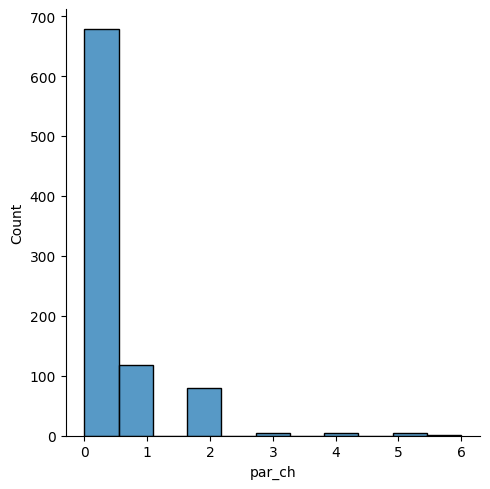

In [98]:
sns.displot(train, x="par_ch")

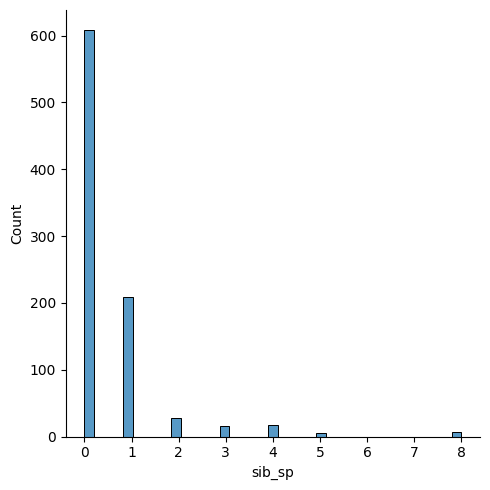

In [99]:
sns.displot(train, x="sib_sp")

In [100]:
train[["sib_sp", "par_ch"]].describe()

,sib_sp,par_ch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


In [101]:
train[["survived", "sib_sp", "par_ch"]].corr(method="spearman")

,survived,sib_sp,par_ch
survived,1.000000,0.088879,0.138266
sib_sp,0.088879,1.000000,0.450014
par_ch,0.138266,0.450014,1.000000


Vendo a baixa correlação e o fato que a distribuição é extremamente enviesada a direita, a feature por si só talvez não seja tão interessante. Considerando passageiros sozinhos em comparação aos acompanhados, vemos que os sozinhos de fato sobreviveram menos que os acompanhados de algum membro da família.

In [102]:
alone = train.loc[(train["sib_sp"].eq(0)) & (train["par_ch"].eq(0))]["survived"]
percentual_alone = sum(alone) / len(alone)

print("Percentual de passageiros sozinhos sobreviventes:", percentual_alone)

Percentual de passageiros sozinhos sobreviventes: 0.30353817504655495


In [103]:
family = train.loc[(train["sib_sp"].ne(0)) | (train["par_ch"].ne(0))]["survived"]
percentual_family = sum(family) / len(family)

print("Percentual de passageiros com familía sobreviventes:", percentual_family)

Percentual de passageiros com familía sobreviventes: 0.5056497175141242


In [104]:
company_df = train.loc[:, ("survived", "sib_sp", "par_ch")]
company_df["alone"] = np.logical_and(
    (company_df["sib_sp"].eq(0)), (company_df["par_ch"].eq(0))
)
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   survived  891 non-null    int64
 1   sib_sp    891 non-null    int64
 2   par_ch    891 non-null    int64
 3   alone     891 non-null    bool 
dtypes: bool(1), int64(3)
memory usage: 21.9 KB


Vemos um aumento razoável na correlação entre sobrevivência e passageiros sozinhos, tendo uma correlação moderada agora. Esse Feature pode ser mais interessante de ser usado no fim.

In [105]:
company_df.corr()

,survived,sib_sp,par_ch,alone
survived,1.000000,-0.035322,0.081629,-0.203367
sib_sp,-0.035322,1.000000,0.414838,-0.584471
par_ch,0.081629,0.414838,1.000000,-0.583398
alone,-0.203367,-0.584471,-0.583398,1.000000


##### Portos mais próximos ao destino influenciaram na sobrevivência.

Essa hipótese é mais para explorar o impacto do porto atracado na sobrevivência.

In [106]:
embarked_df = train.loc[:, ["survived", "embarked"]]
# removendo os dois que não tem informação, assumindo que eles nunca embarcaram.
embarked_df = embarked_df.dropna(subset=["embarked"])
embarked_df["embarked"] = embarked_df["embarked"].replace(
    {
        "S": 1,
        "C": 2,
        "Q": 3,
    }
)
embarked_df["embarked"] = pd.to_numeric(embarked_df["embarked"])
embarked_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   survived  889 non-null    int64
 1   embarked  889 non-null    int64
dtypes: int64(2)
memory usage: 20.8 KB


In [107]:
embarked_df.corr()

,survived,embarked
survived,1.000000,0.108669
embarked,0.108669,1.000000


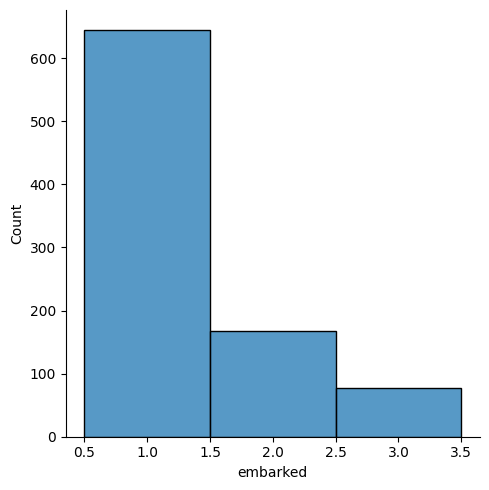

In [108]:
sns.displot(embarked_df, x="embarked", discrete=True)

In [109]:
south = embarked_df.loc[embarked_df["embarked"].eq(3)]["survived"]
percentual_south = sum(south) / len(south)

print("Percentual de Southampton classe sobrevivente:", percentual_south)

Percentual de Southampton classe sobrevivente: 0.38961038961038963


In [110]:
cherbourg = embarked_df.loc[embarked_df["embarked"].eq(2)]["survived"]
percentual_cherbourg = sum(cherbourg) / len(cherbourg)

print("Percentual de Cherbourg classe sobrevivente:", percentual_cherbourg)

Percentual de Cherbourg classe sobrevivente: 0.5535714285714286


In [111]:
queen = embarked_df.loc[embarked_df["embarked"].eq(3)]["survived"]
percentual_queen = sum(queen) / len(queen)

print("Percentual de Queenstown classe sobrevivente:", percentual_queen)

Percentual de Queenstown classe sobrevivente: 0.38961038961038963


A diferença não é tão alta, sendo um feature que será descartado, ao menos inicialmente.